
## Generalized mean
We use the [weighted generalized mean](https://en.wikipedia.org/wiki/Generalized_mean) to blend our predictions.  

$$
\bar{x}
= \left( \sum_{i=1}^n w_i x_i^p \right)^{1/p}
$$

We tuned the weights and $p$ using the optuna library.

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from functools import partial
from sklearn.metrics import mean_squared_error

/home/jane/3005/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
%%time
SUBMISSION_PATH = '../ASHRAE/submissions'
root = '../ASHRAE/input'
test = pd.read_csv(f'{root}/test.csv')
meta = pd.read_csv(f'{root}/building_metadata.csv')

CPU times: user 12.6 s, sys: 1.09 s, total: 13.7 s
Wall time: 13.7 s


In [3]:
leak = pd.read_csv(f'{root}/leak.csv')

leak.fillna(0, inplace=True)
leak.timestamp = pd.to_datetime(leak.timestamp)
leak = leak[(leak.timestamp.dt.year > 2016) & (leak.timestamp.dt.year < 2019)]
leak.loc[leak.meter_reading < 0, 'meter_reading'] = 0 # remove negative values
leak = leak[leak.building_id != 245]
leak.timestamp = leak.timestamp.astype('str')

# Leak Validation for my submissions (not used leak data)

In [9]:
submission_list = [   
    'submission_3fokd_lgb_optuna_opt',
    'submission_lgb_optuna_7tr',
    'submission_4_meter_type_var2'
    ]

for i,f in enumerate(submission_list):
    x = pd.read_csv(f'{SUBMISSION_PATH}/{f}.csv', index_col=0).meter_reading
    x[x < 0] = 0
    test[f'pred{i}'] = x

del  x

/home/jane/3005/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [10]:
leak = pd.merge(leak, test[['building_id', 'meter', 'timestamp', *[f"pred{i}" for i in range(len(submission_list))], 'row_id']], "left")
leak = pd.merge(leak, meta[['building_id', 'site_id']], 'left')

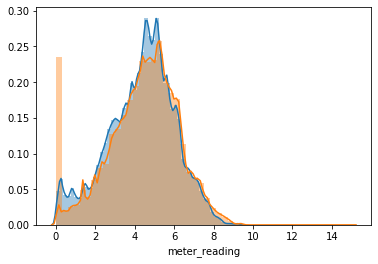

score0=0.9903213224370578


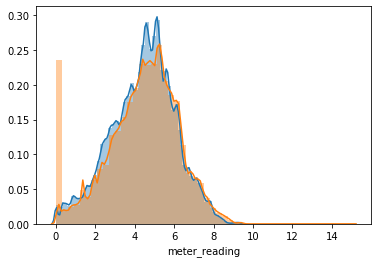

score1=0.9951637144178449


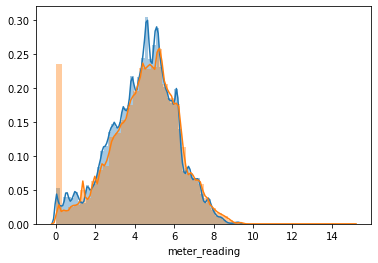

score2=0.9823259888711454


In [11]:
for i in range(len(submission_list)):
    sns.distplot(np.log1p(leak[f"pred{i}"]))
    sns.distplot(np.log1p(leak.meter_reading))
    plt.show()
    leak_score = np.sqrt(mean_squared_error(np.log1p(leak[f"pred{i}"]), np.log1p(leak.meter_reading)))
    print(f'score{i}={leak_score}')    

# Leak Validation for Blending

In [12]:
# log1p then mean
log1p_then_mean = np.mean(np.log1p(leak[[f"pred{i}" for i in range(len(submission_list))]].values), axis=1)
leak_score = np.sqrt(mean_squared_error(log1p_then_mean, np.log1p(leak.meter_reading)))
print('log1p then mean score =', leak_score)

log1p then mean score = 0.9793008571618776


In [13]:
# mean then log1p
mean_then_log1p = np.log1p(np.mean(leak[[f"pred{i}" for i in range(len(submission_list))]].values, axis=1))
leak_score = np.sqrt(mean_squared_error(mean_then_log1p, np.log1p(leak.meter_reading)))
print('mean then log1p score=', leak_score)

mean then log1p score= 0.9810201303242858


In [14]:
del log1p_then_mean
del mean_then_log1p
gc.collect()

28390

## Tune with Optuna

In [15]:
class GeneralizedMeanBlender():
    """Combines multiple predictions using generalized mean"""
    def __init__(self, p_range=(-2,2)):
        """"""
        self.p_range = p_range
        self.p = None
        self.weights = None
                
    def _objective(self, trial, X, y):
                    
        # create hyperparameters
        p = trial.suggest_uniform(f"p", *self.p_range)
        weights = [
            trial.suggest_uniform(f"w{i}", 0, 1)
            for i in range(X.shape[1])
        ]

        # blend predictions
        blend_preds, total_weight = 0, 0
        if p <= 0:
            for j,w in enumerate(weights):
                blend_preds += w*np.log1p(X[:,j])
                total_weight += w
            blend_preds = np.expm1(blend_preds/total_weight)
        else:
            for j,w in enumerate(weights):
                blend_preds += w*X[:,j]**p
                total_weight += w
            blend_preds = (blend_preds/total_weight)**(1/p)
            
        # calculate mean squared error
        return np.sqrt(mean_squared_error(y, blend_preds))

    def fit(self, X, y, n_trials=10): 
        # optimize objective
        obj = partial(self._objective, X=X, y=y)
        study = optuna.create_study()
        study.optimize(obj, n_trials=n_trials)
        # extract best weights
        if self.p is None:
            self.p = [v for k,v in study.best_params.items() if "p" in k][0]
        self.weights = np.array([v for k,v in study.best_params.items() if "w" in k])
        self.weights /= self.weights.sum()

    def transform(self, X): 
        assert self.weights is not None and self.p is not None,\
        "Must call fit method before transform"
        if self.p == 0:
            return np.expm1(np.dot(np.log1p(X), self.weights))
        else:
            return np.dot(X**self.p, self.weights)**(1/self.p)
    
    def fit_transform(self, X, y, **kwargs):
        self.fit(X, y, **kwargs)
        return self.transform(X)

In [16]:
X = np.log1p(leak[[f"pred{i}" for i in range(len(submission_list))]].values)
y = np.log1p(leak["meter_reading"].values)

gmb = GeneralizedMeanBlender()
gmb.fit(X, y, n_trials=20)

[I 2020-02-21 21:27:10,132] Finished trial#0 resulted in value: 0.9828884083195571. Current best value is 0.9828884083195571 with parameters: {'p': 0.10742227685841632, 'w0': 0.9167620497432012, 'w1': 0.24495844651844234, 'w2': 0.15456720790164336}.
[I 2020-02-21 21:27:12,867] Finished trial#1 resulted in value: 0.984484665264031. Current best value is 0.9828884083195571 with parameters: {'p': 0.10742227685841632, 'w0': 0.9167620497432012, 'w1': 0.24495844651844234, 'w2': 0.15456720790164336}.
[I 2020-02-21 21:27:15,648] Finished trial#2 resulted in value: 0.9831417129813529. Current best value is 0.9828884083195571 with parameters: {'p': 0.10742227685841632, 'w0': 0.9167620497432012, 'w1': 0.24495844651844234, 'w2': 0.15456720790164336}.
[I 2020-02-21 21:27:16,568] Finished trial#3 resulted in value: 0.9829808001064703. Current best value is 0.9828884083195571 with parameters: {'p': 0.10742227685841632, 'w0': 0.9167620497432012, 'w1': 0.24495844651844234, 'w2': 0.15456720790164336}.
[

In [17]:
print(np.sqrt(mean_squared_error(gmb.transform(X), np.log1p(leak.meter_reading))))

/home/jane/3005/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in power



0.9762980883270737


# Submit

In [18]:
# make test predictions
sample_submission = pd.read_csv(f'{SUBMISSION_PATH}/sample_submission.csv')
X_test = test[[f"pred{i}" for i in range(len(submission_list))]].values
predictions = np.expm1(gmb.transform(np.log1p(X_test)))
sample_submission['meter_reading'] = predictions
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

# fill in leak data
leak = leak[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak.index, 'meter_reading'] = leak['meter_reading']

# save submission
sample_submission.to_csv(f'{SUBMISSION_PATH}/submission_gwm3.csv', index=False, float_format='%.4f')
sample_submission.head()

/home/jane/3005/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in power



,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666


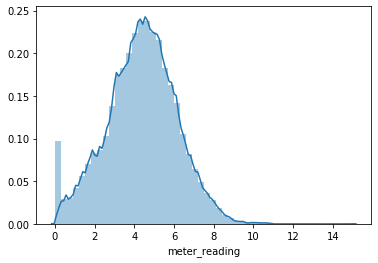

In [19]:
sns.distplot(np.log1p(sample_submission.meter_reading))